# 미니프로젝트의 목표!

### Objective 1 : 비정상 데이터를 정상 데이터로 만들자!

### Objective 2: 강의에 활용되었던 분류 모델의 성능을 높여보자!

#### ① 비정상 데이터를 정상 데이터로 만들기

In [4]:
# 먼저 데이터가 저장된 폴더를 연결합시다.
!mkdir -p aiffel/time_series_basic
#!ln -s data/* aiffel/time_series_basic
!cp ../data/AirPassengers.csv aiffel/time_series_basic/

In [5]:
!pip install tsfresh

In [ ]:
# 라이브러리 버전 충돌을 피하기 위해 런타임을 재시작합니다.
import os
os.kill(os.getpid(), 9)

In [1]:
# 라이브러리 불러오기 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# air passengers 데이터 불러오기
ap = pd.read_csv('/aiffel/aiffel/time_series_basic/AirPassengers.csv')

ap.drop('Month', axis = 1, inplace = True)#비정상 데이터를 정상 데이터로 만드는 데에 Month가 필요없어서 빼준다.

In [3]:
ap

,#Passengers
0,112
1,118
2,132
3,129
4,121
...,...
139,606
140,508
141,461
142,390


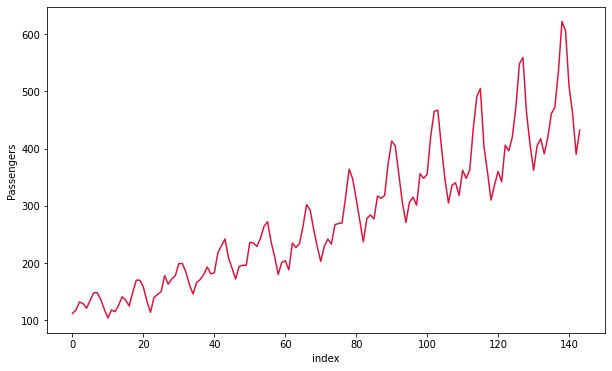

In [67]:
plt.figure(figsize = (10,6))
plt.plot(ap, color = "crimson")
plt.xlabel('index')
plt.ylabel('Passengers')
plt.show()

           상승추세 - 비정상데이터

#### ② 분산을 일정하게 만들기 - log transformation

In [9]:
# np.log를 통해서 log transformation
log_transformed = np.log(ap)

In [10]:
log_transformed

,#Passengers
0,4.718499
1,4.770685
2,4.882802
3,4.859812
4,4.795791
...,...
139,6.406880
140,6.230481
141,6.133398
142,5.966147


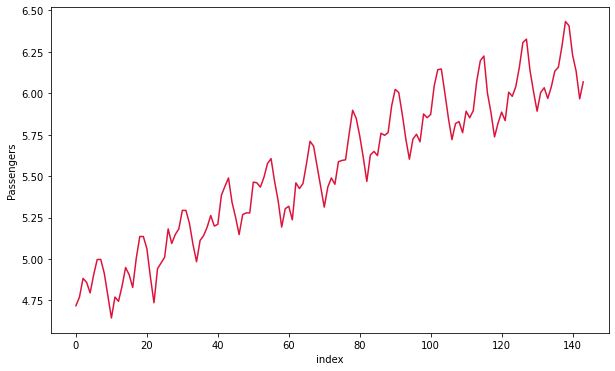

In [62]:
# 분산이 일정해진 것을 눈으로 확인할 수 있음
plt.figure(figsize = (10,6))
plt.xlabel('index')
plt.ylabel('Passengers')
plt.plot(log_transformed, color = 'crimson')
plt.show()

           그래프를 봤을 때 증가하던 분산이 통제된 것을 볼 수 있음

#### ③ 차분을 통해 추세 제거하기

In [12]:
# diff() 함수를 통해 간단하게 차분을 수행할 수 있음
diffed = log_transformed.diff()[1:]

    차분을 수행하면 데이터가 짧아지므로 꼭 데이터를 잘라서 쓰거나, 차분을 하게되면 데이터에 NaN값이 들어가므로 그 값을 제거하고 활용

In [13]:
diffed

,#Passengers
1,0.052186
2,0.112117
3,-0.022990
4,-0.064022
5,0.109484
...,...
139,-0.026060
140,-0.176399
141,-0.097083
142,-0.167251


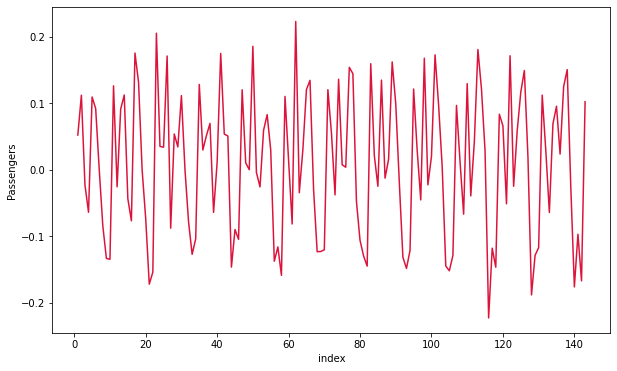

In [68]:
# 커지는 분산과 증가하는 추세를 제거한 air passengers 데이터를 얻을 수 있다
plt.figure(figsize = (10,6))
plt.plot(diffed, color = 'crimson')
plt.xlabel('index')
plt.ylabel('Passengers')
plt.show()

    평균은 0이고 분산은 커지지 않는 airpassengers 데이터를 얻게 됨

#### ④ (추가) 계절 차분을 통해 계절성 제거하기

In [18]:
seasonally_diffed = diffed.diff(12) # diff에 12라는 값을 넣어주면 주기를 12로 하는 계절 차분을 수행할 수 있음
seasonally_diffed.dropna(inplace = True) # 차분을 하면 데이터가 짧아지기때문에 빈칸을 제거해야함

    의문점 계절차분의 계절성 12는 어떻게 알 수 있는가? 1년 12개월? 혹은 첫번째 그래프상에서??

In [19]:
seasonally_diffed # 아래 데이터는 dropna를 적용하기 전 데이터의 형태. 살펴보기 위해 먼저 확인

,#Passengers
13,0.039164
14,0.000361
15,-0.020496
16,-0.012939
17,0.066148
...,...
139,-0.045934
140,0.012024
141,0.031830
142,-0.050082


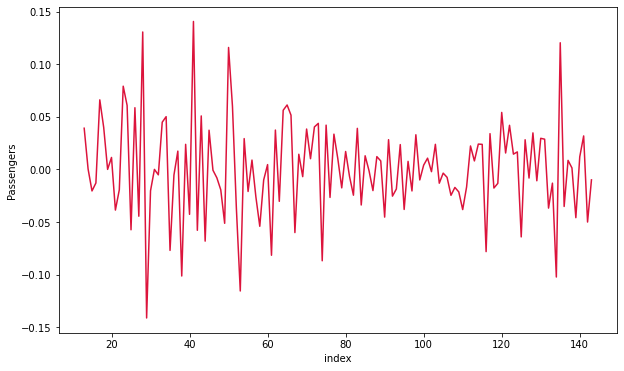

In [69]:
# 아래와 같은 데이터를 얻을 수 있음
plt.figure(figsize = (10,6))
plt.plot(seasonally_diffed, color = 'crimson')
plt.xlabel('index')
plt.ylabel('Passengers')
plt.show()

        그래프를 시각적으로 보았을 때 분산이 움직이는 것 같기도 하고 아닌것 같기도하다. (정상성을 띄는지 의문이 든다.)
        검정을 통해 확인할 것

#### ⑤ 검정을 통해 정상성 확인하기

In [21]:
from statsmodels.tsa.stattools import adfuller

def adf_test(x): # adf검정을 위한 함수 정의
    stat, p_value, lags, nobs, crit, icb = adfuller(x) # adfuller 함수를 이용하면 6가지 output이 나옵니다
    print('ADF statistics')
    print(stat) # ADF 검정 통계량입니다
    print('P-value')
    print(p_value) # P-value입니다

In [22]:
adf_test(seasonally_diffed) # 계절차분까지 수행한 데이터에 대해 adf테스트를 수행

ADF statistics
-4.443324941831123
P-value
0.0002485912311384052


    유의수준 0.01에서 단위근이 존재한다는 귀무가설을 기각하고 시계열은 정상적이다는 대립가설을 채택할 수 있음

#### ⑥ 시계열 분류

In [23]:
# ⑥-1 : 데이터 다운로드 및 불러오기
from tsfresh.examples.robot_execution_failures import download_robot_execution_failures, load_robot_execution_failures

# 수업때 보았던 robot exection failures데이터를 로드
download_robot_execution_failures()
timeseries, y = load_robot_execution_failures()

In [24]:
# ⑥-2 : 데이터셋 확인(timeseries와 y 확인)
timeseries # id, time을 제외하고 6개 column의 X변수가 나타남

,id,time,F_x,F_y,F_z,T_x,T_y,T_z
0,1,0,-1,-1,63,-3,-1,0
1,1,1,0,0,62,-3,-1,0
2,1,2,-1,-1,61,-3,0,0
3,1,3,-1,-1,63,-2,-1,0
4,1,4,-1,-1,63,-3,-1,0
...,...,...,...,...,...,...,...,...
1315,88,10,-10,2,39,-21,-24,5
1316,88,11,-11,2,38,-24,-22,6
1317,88,12,-12,3,23,-24,-24,5
1318,88,13,-13,4,26,-29,-27,5


In [25]:
y # true/false가 제시되어 있음

1      True
2      True
3      True
4      True
5      True
      ...  
84    False
85    False
86    False
87    False
88    False
Length: 88, dtype: bool

In [27]:
# ⑥-3 : 데이터셋 가공
def custom_classification_split(x,y,test_size=0.3): # 수업때 보았던 custom split 함수
    
    num_true = int(y.sum()*test_size)
    num_false = int((len(y)-y.sum())*test_size)
    
    id_list = y[y==False].head(num_false).index.to_list() + y[y==True].head(num_true).index.to_list()
    
    y_train = y.drop(id_list)
    y_test = y.iloc[id_list].sort_index()
    X_train = timeseries[~timeseries['id'].isin(id_list)]
    X_test = timeseries[timeseries['id'].isin(id_list)]
    
    return X_train, y_train, X_test, y_test

In [28]:
# ⑥-4 : 데이터셋 나누기
X_train, y_train, X_test, y_test = custom_classification_split(timeseries, y, test_size = 0.25)

    EfficientParameters는 큰 계산비용이 필요한 calculator를 제외하고 가능한 모든 특징들을 생성한다.

In [70]:
from tsfresh import extract_features
from tsfresh.feature_extraction import EfficientFCParameters
from tsfresh.utilities.dataframe_functions import impute

settings = EfficientFCParameters()

    impute : 간단하게 데이터들의 null값을 정리해주는 역할을 함.

In [30]:
# ⑥-5 : Feature extraction
comprehensive_features_train = extract_features(
                                    X_train, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 402/402 [00:15<00:00, 25.59it/s]


In [31]:
comprehensive_features_test = extract_features(
                                    X_test, 
                                    column_id="id",
                                    column_sort="time",
                                    default_fc_parameters=settings
                                          )

Feature Extraction: 100%|██████████| 126/126 [00:04<00:00, 27.28it/s]


    impute를 통해 간단하게 데이터 전처리

In [33]:
# ⑥-6 : impute
impute(comprehensive_features_train)

,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
6,1.0,1.0,1.0,1.0,-15.0,39.0,1.714286,0.142857,0.153846,-1.0,...,0.974315,1.213008,1.732868,1.438883,1.863680,2.145842,2.163956,2.197225,0.0,0.714286
7,0.0,1.0,0.0,1.0,-13.0,21.0,0.928571,0.214286,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.043794,1.349792,1.666333,1.748067,1.831020,0.0,0.428571
8,1.0,0.0,1.0,1.0,-10.0,26.0,1.142857,-0.142857,0.192308,-1.0,...,1.494175,1.732868,2.079442,1.412745,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
9,1.0,0.0,0.0,1.0,-10.0,24.0,1.428571,0.000000,-0.076923,-1.0,...,1.255482,1.494175,2.079442,1.479133,2.138333,2.397895,2.302585,2.197225,0.0,1.285714
10,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,0.000000,-1.0,...,0.937285,1.213008,1.906155,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,1.0,1.0,0.0,1.0,-1073.0,96833.0,7.142857,-5.428571,-0.038462,-98.0,...,0.735622,0.735622,1.386294,1.585771,2.253858,2.397895,2.302585,2.197225,0.0,24.285714
85,1.0,0.0,1.0,1.0,143.0,1683.0,1.357143,1.071429,0.076923,8.0,...,0.735622,0.735622,1.667462,1.332245,1.589027,1.893788,2.163956,2.197225,0.0,5.571429
86,1.0,0.0,0.0,0.0,961.0,83497.0,9.071429,9.071429,0.807692,52.0,...,0.735622,1.073543,1.732868,0.687092,0.983088,1.159589,1.227529,1.303092,0.0,9.285714
87,1.0,1.0,0.0,1.0,4509.0,1405437.0,12.928571,12.214286,-1.038462,338.0,...,0.735622,0.735622,1.386294,0.535961,0.836988,1.159589,1.497866,1.581094,0.0,40.285714


In [34]:
impute(comprehensive_features_test)

/opt/conda/lib/python3.9/site-packages/tsfresh/utilities/dataframe_functions.py:198: RuntimeWarning: The columns ['F_x__partial_autocorrelation__lag_7'
 'F_x__partial_autocorrelation__lag_8'
 'F_x__partial_autocorrelation__lag_9' ...
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"mean"'
 'T_z__agg_linear_trend__attr_"stderr"__chunk_len_50__f_agg_"var"'
 'T_z__query_similarity_count__query_None__threshold_0.0'] did not have any finite values. Filling with zeros.
  warnings.warn(


,F_x__variance_larger_than_standard_deviation,F_x__has_duplicate_max,F_x__has_duplicate_min,F_x__has_duplicate,F_x__sum_values,F_x__abs_energy,F_x__mean_abs_change,F_x__mean_change,F_x__mean_second_derivative_central,F_x__median,...,T_z__fourier_entropy__bins_5,T_z__fourier_entropy__bins_10,T_z__fourier_entropy__bins_100,T_z__permutation_entropy__dimension_3__tau_1,T_z__permutation_entropy__dimension_4__tau_1,T_z__permutation_entropy__dimension_5__tau_1,T_z__permutation_entropy__dimension_6__tau_1,T_z__permutation_entropy__dimension_7__tau_1,T_z__query_similarity_count__query_None__threshold_0.0,T_z__mean_n_absolute_max__number_of_maxima_7
1,0.0,0.0,1.0,1.0,-14.0,14.0,0.142857,0.000000,-0.038462,-1.0,...,1.073543,1.440235,2.079442,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.0,0.000000
2,0.0,1.0,1.0,1.0,-13.0,25.0,1.000000,0.000000,-0.038462,-1.0,...,1.073543,1.494175,2.079442,0.937156,1.234268,1.540306,1.748067,1.831020,0.0,0.571429
3,0.0,0.0,1.0,1.0,-10.0,12.0,0.714286,0.000000,-0.038462,-1.0,...,1.386294,1.732868,2.079442,1.265857,1.704551,2.019815,2.163956,2.197225,0.0,0.571429
4,0.0,1.0,1.0,1.0,-6.0,16.0,1.214286,-0.071429,-0.038462,0.0,...,1.073543,1.494175,2.079442,1.156988,1.907284,2.397895,2.302585,2.197225,0.0,1.000000
5,0.0,0.0,0.0,1.0,-9.0,17.0,0.928571,-0.071429,0.038462,-1.0,...,0.900256,1.320888,2.079442,1.156988,1.863680,2.271869,2.302585,2.197225,0.0,0.857143
19,1.0,0.0,0.0,1.0,99.0,6109.0,13.928571,-1.928571,-1.730769,1.0,...,0.974315,1.494175,1.906155,1.230932,1.704551,2.019815,2.025326,2.043192,0.0,1.428571
20,1.0,0.0,1.0,1.0,155.0,34455.0,16.714286,-13.142857,7.576923,-1.0,...,1.386294,1.667462,2.079442,1.564957,2.022809,2.271869,2.302585,2.197225,0.0,2.571429
21,1.0,0.0,0.0,1.0,-171.0,16495.0,20.928571,1.785714,3.961538,-1.0,...,0.735622,0.735622,0.735622,1.303876,1.791759,2.271869,2.302585,2.197225,0.0,17.285714
22,1.0,0.0,0.0,1.0,102.0,12700.0,10.785714,-8.071429,4.500000,-1.0,...,0.562335,0.735622,1.732868,1.524707,2.138333,2.397895,2.302585,2.197225,0.0,5.428571
23,1.0,0.0,0.0,1.0,67.0,10593.0,15.142857,-7.000000,3.000000,-3.0,...,0.974315,1.255482,2.079442,1.519383,2.369382,2.397895,2.302585,2.197225,0.0,3.714286


   ###     Random Forest 모델 활용

In [35]:
# ⑥-7 : RandomForest 사용 및 score 확인
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(n_estimators = 10, max_depth = 3)

rf_clf.fit(comprehensive_features_train, y_train)

RandomForestClassifier(max_depth=3, n_estimators=10)

In [36]:
rf_clf.score(comprehensive_features_test, y_test) # test셋에 적합해본 결과 약 0.66의 정확도를 보이며 불만족스러운 결과를 확인할 수 있습니다.

0.8571428571428571

### XGBoost 활용

In [37]:
# ⑥-7 : XGBoost 사용 및 score 확인
import xgboost as xgb
xgb_clf = xgb.XGBClassifier(n_estimators = 10, max_depth = 3)

xgb_clf.fit(comprehensive_features_train, y_train)

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:57:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [38]:
xgb_clf.score(comprehensive_features_test, y_test)

1.0

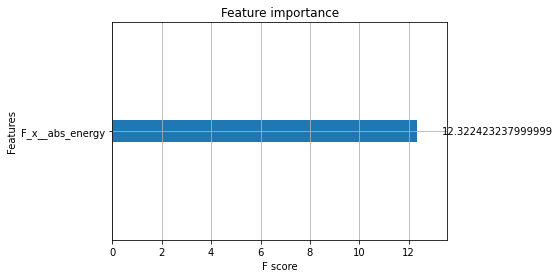

In [39]:
# ⑥-8 : XGBoost plot_importance 확인 및 시각화
xgb.plot_importance(xgb_clf, importance_type = 'gain') # plot_importance를 통해 어떤 변수(특징)가 가장 유의미한지 확인
plt.show()

In [40]:
sum(xgb_clf.feature_importances_ != 0) # Fx값의 abs_energy특징만의 유의미함

1

In [83]:
# ⑥-9 : Classification report를 통한 검증 및 분석
from sklearn.metrics import classification_report

classification_report(y_test, xgb_clf.predict(comprehensive_features_test), target_names = ['true', 'false'], output_dict = True)

{'true': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 16},
 'false': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 'accuracy': 1.0,
 'macro avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21},
 'weighted avg': {'precision': 1.0,
  'recall': 1.0,
  'f1-score': 1.0,
  'support': 21}}

### LogisticRegression 활용

In [75]:
from sklearn.linear_model import LogisticRegression

In [77]:
lr_clf = LogisticRegression()

In [80]:
lr_clf.fit(comprehensive_features_train, y_train)
lr_clf.score(comprehensive_features_test, y_test)

0.5714285714285714

In [82]:
classification_report(y_test, lr_clf.predict(comprehensive_features_test), target_names=['true', 'false'], output_dict=True)

{'true': {'precision': 1.0,
  'recall': 0.4375,
  'f1-score': 0.6086956521739131,
  'support': 16},
 'false': {'precision': 0.35714285714285715,
  'recall': 1.0,
  'f1-score': 0.5263157894736842,
  'support': 5},
 'accuracy': 0.5714285714285714,
 'macro avg': {'precision': 0.6785714285714286,
  'recall': 0.71875,
  'f1-score': 0.5675057208237986,
  'support': 21},
 'weighted avg': {'precision': 0.846938775510204,
  'recall': 0.5714285714285714,
  'f1-score': 0.5890813991500491,
  'support': 21}}

프로젝트 회고

tsfresh를 설치하였고, 런타임 재시작, 라이브러리 import, 데이터 불러오기 등의 과정을 거쳤다.

데이터를 출력해보았을 때 전체가 수치로만 이루어져 있어서 데이터를 보는 것이 매우 낯설게 느껴졌다.

단순히 노드의 개념들을 이해한 상태에서 설명 영상에 따라 코드를 진행하였고, 코드를 하나하나 뜯어보면서 과정을 이해해보았다.

분산을 일정하게 만들기 위한 log transformation을 진행하였다. 

검정을 통해 정상성을 확인하는 과정에서 p-value의 값을 통해 귀무가설의 개념을 복기하였고, 귀무가설을 버리고 정상성을

획득하였다고 말할 수 있는지를 이해하게 되었다. 

ADF statistics
-4.443324941831123
P-value
0.0002485912311384052

그룹스터디를 통해 소명님에게 시각화에 관한 효과적인 방법들을 배울 수 있었다.

12개월을 주기로 하는 계절성 부문에 대한 의문이 들었다.

정확도는 '전체 데이터중에, 정확하게 예측한 데이터의 수'라고 할 수 있다. 하지만 정확도를 분류 모델의 평가 지표로 사용할 때는 주의해야 하는데, 특히 불균형한 데이터(imbalanced data)의 경우에 정확도는 적합한 평가지표가 아니다.

정밀도는 '양성으로 판단한 것 중, 진짜 양성의 비율'을 말한다.

재현율은 '진짜 양성인 것들 중에서, 올바르게 양성으로 판단한 비율'이다. 
양성 결과를 정확히 예측하는 능력으로, 모델의 완정 성을 평가하는 지표로 사용된다.

F1 Score는 보통 불균형 분류문제에서 평가척도로 주로 사용된다. 
데이터가 불균형한 상태에서 Accuracy로 성능을 평가하기엔 데이터 편향성이 너무 크게 나타나 올바르게 성능을 측정하기 힘들다. 
그렇기 때문에 F1 Score를 평가척도로 사용한다.


